<a id="Introduction"></a> 

<img src="https://triuminfo.com/application/views/images/sales_forecasting_banner.jpg">

<center><h1>💰 Store Sales💰</h1></center>

# Introduction 

What is the most stores and grocery families that is most consumend on our markets? 🤔

does those sales got affected by seasonality (holidays) or by any trend?

Well, you can't imagine consumer behavior... if you want we can test it, you can find a correlation anywhere you look ... if you're really, deeply paying attention.


> **🟢 Goal**: This notebook has the purpose of analysing and predicting Sales prices to generate more products to be sold on our stores, as well as identifying if there is any impact for seasonality on the prices.

 Manily our stores are located on Ecuador, and we need to imporve our sales in different states. 

Corporación Favorita, a large Ecuadorian-based grocery retailer.

### 📚 Libraries & Functions

In [4]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'store-sales-time-series-forecasting'
! unzip store-sales-time-series-forecasting.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 23% 5.00M/21.4M [00:00<00:00, 38.4MB/s]
100% 21.4M/21.4M [00:00<00:00, 118MB/s] 
Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [5]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from statsmodels.tsa.stattools import adfuller       ### Augmented Dickey Fuller

# set style 

plt.style.use('seaborn-darkgrid')

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

class clr:
    S = '\033[1m' + '\033[95m'
    E = '\033[0m'


# Color palette

my_colors = ["#ce8f5a", "#efd199", "#80c8bc", "#5ec0ca", "#6287a2"]

In [6]:
# ===== DICKEY FULLER TEST =====

def test_stationarity(x, log='non-stationary'):
    
    """Test stationarity of a time Series variable."""
    
    # Perform Dicky Fuller test 
    
    result = adfuller(x)
    
    print("ADF statistic: {}".format(result[0]))
    
    print("p-value: {}".format(result[1]))
    
    for key, value in result[4].items():
        
        if result[0] > value:
            print (clr.S + "The graph is non-stationary! (it has a trend)" + clr.E)
            
            break
            
        else: 
            print (clr.S + "The graph is stationary! (it doesn't have a trend)" + clr.E)
            
            break
            
    print("Critical values:")
    
    for key,value in result[4].items():
        
        print("\t%s: %.3f " %(key, value))
        
    # Determine rolling statistics 
    
    rolmean = x.rolling(window=22, center=False).mean()
    
    rolstd = x.rolling(window=22, center=False).std()
    
    # Plot rolling statistics:
    
    plt.figure(figsize= (25, 11))
    
    orig = plt.plot(x, color = my_colors[0], lw=8, label = "Original")
    
    mean = plt.plot(rolmean, color = my_colors[2], lw=2.5, ls= '--', label = 'Rolling Mean')
    
    std = plt.plot(rolmean, color = my_colors[3], lw=3, label = 'Rolling Std')
    
    plt.legend(loc='best', fontsize=20)
    
    plt.title('Rolling Mean & Standard Deviation', size=25)
    
    plt.show(block=False)
    
        

In [8]:
# Run this to enable CSS stype
# WARNING: run it in a separate cell, not alongside other code blocks too
from IPython.core.display import HTML
def css_styling():
    styles = open("/content/alerts.css", "r").read()
    return HTML("<style>"+styles+"</style>")
css_styling()

<a id="Understand the data "></a> 

# 1. Understand the data 🧐

## 1.1 🏪 Stores overview

<div class="alert simple-alert">
  💡<b>Helpful Notes</b>: 
      
* store_nbr: Identifies the store at which the products are sold.
* city 
* state 
* type
* cluster  
    
</div>


### 📥 Read in Data

In [9]:
%%time 

stores = pd.read_csv("/content/stores.csv")

CPU times: user 6.34 ms, sys: 899 µs, total: 7.24 ms
Wall time: 7.42 ms


In [10]:
stores.head() 

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


![](https://besthotelshome.com/wp-content/uploads/2020/03/Map-of-Ecuador.jpg)

In [12]:
stores.state.unique() 


# we will focus manil with two states "Pichincha" where the capital of ecuador is located ('Quito')
# and "Guayas" where the largest city in Ecuador is located ('Guayaquil'). 

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [13]:
stores.city.unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [14]:
no_of_cities = len(stores.city.unique())
no_of_states = len(stores.state.unique()) 

In [15]:
print(clr.S+f"Our stores are manily located in {no_of_states} differnet states and in particular {no_of_cities} different cities."+clr.E)

Our stores are manily located in 16 differnet states and in particular 22 different cities.


In [16]:
print(clr.S+"Our unique stores:"+clr.E, stores.store_nbr.unique())

Our unique stores: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54]


In [17]:
stores_per_state_per_city = stores.groupby(['state','city'])['store_nbr'].count().reset_index()

In [18]:
px.bar(stores_per_state_per_city, x = 'city', y = 'store_nbr', color='state', 
       labels = dict(city= 'City', store_nbr='Number of Stores'),
    title = 'Stores per state and city ')

> Increase Plot size 

> We can **Conclude** by looking on this chart that Only 5 states have more than 2 stores. From 10th states, there is only one store per state.

<a id = 'train dataset overview'></a>

## 1.2  train dataset overview

<div class="alert simple-alert">
  💡<b>Helpful Notes</b>: 
      
* 3+ million store records.
* store_nbr: Identifies the store at which the products are sold. 
* family: Type of product sold. 
* Sales: Total sales at a given date. 
* onpromotion: Total number of items in a product family that were being promoted.
    
</div>

In [20]:
%%time

train = pd.read_csv('/content/train.csv', index_col=0)

CPU times: user 5.31 s, sys: 600 ms, total: 5.91 s
Wall time: 8.03 s


In [21]:
train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [22]:
print(clr.S+f"The dataset contains {train.shape[0]} rows "+clr.E)
print(clr.S+f"The dataset contains {train.shape[1]} coulmns"+clr.E)

train.isna().sum()

The dataset contains 3000888 rows 
The dataset contains 5 coulmns


date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

<div class="alert simple-alert">
  <p>💡<b>Note</b>: Note that we have no missing values on our dataset :) </p>
</div>

In [23]:
print(clr.S+ "Our stores is build on these types of groceries:"+clr.E, train.family.unique())

Our stores is build on these types of groceries: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [24]:
len(train.family.unique())

33

In [25]:
train.sales.mean()

357.77574911262707

In [26]:
sales_per_family_mean = train.groupby('family')['sales'].mean().sort_values(ascending=False).reset_index()

In [27]:
px.bar(sales_per_family_mean, x='family', y='sales', 
       labels = dict(family='Category', sales='Average Sales'),
       title = "Average Sales Per Category")

In [28]:
print(clr.S+ f"WE got over {train.family.nunique()} unique and different categories on our stores."+clr.E)

WE got over 33 unique and different categories on our stores.


In [29]:
train.info() # to check our coulmns data types 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 137.4+ MB


<div class="alert warning-alert">
  <p>💡<b>Note</b>: we can see that our data in memort usage is above 135 MB, some data types need to be changed</p>
</div>


In [30]:
train['date'] = pd.to_datetime(train['date'])

In [31]:
train['year'] = train['date'].dt.year
train.head(3)

,date,store_nbr,family,sales,onpromotion,year
id,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013
1,2013-01-01,1,BABY CARE,0.0,0,2013
2,2013-01-01,1,BEAUTY,0.0,0,2013


In [32]:
sales_made_per_year = train.groupby("year")['sales'].sum().reset_index()

sales_made_per_year

,year,sales
0,2013,1.404190e+08
1,2014,2.094742e+08
2,2015,2.408801e+08
3,2016,2.886545e+08
4,2017,1.942171e+08


In [33]:
px.line(sales_made_per_year, x='year', y='sales', 
       labels = dict(year= 'Year', sales='Sales'),
       title= "Sales Made Per Year ")

<div class="alert danger-alert">
  <p>💡<b>Note</b>: We coiuld see that most our sales made was on 2016, but a huge drop could be seen on 2017 for our sales.</p>
</div>

In [34]:
count_sales_per_year = train.groupby("year")['sales'].count().reset_index()

count_sales_per_year

,year,sales
0,2013,648648
1,2014,648648
2,2015,648648
3,2016,650430
4,2017,404514


In [35]:
px.line(count_sales_per_year, x='year', y='sales', 
       labels = dict(year= 'Year', sales='Sales'),
       title= "Number of Sales Per Year")

<div class="alert danger-alert">
  <p>💡<b>Note</b>: Seems like we have a drop in years 2016-2017 overall sales.</p>
</div>

In [36]:
train['month'] = train['date'].dt.month

In [37]:
sales_per_month = train.groupby(['year','month'])['sales'].sum().reset_index()


In [38]:
px.line(sales_per_month, x = 'month', y= 'sales', color='year')

We could see that we start every year with a better sales than the preceding year (excep for 2015 year) which is a good indacator on overall,but we got a couple of peaks that needs further investagations. 

In [39]:
top_5_categories = train.groupby('family')['sales'].mean().sort_values(ascending=False)[:5].reset_index()

<div class="alert simple-alert">
  <p>💡<b>Note</b>:These are the top 5 grocerie types in sales :) </p>
</div>

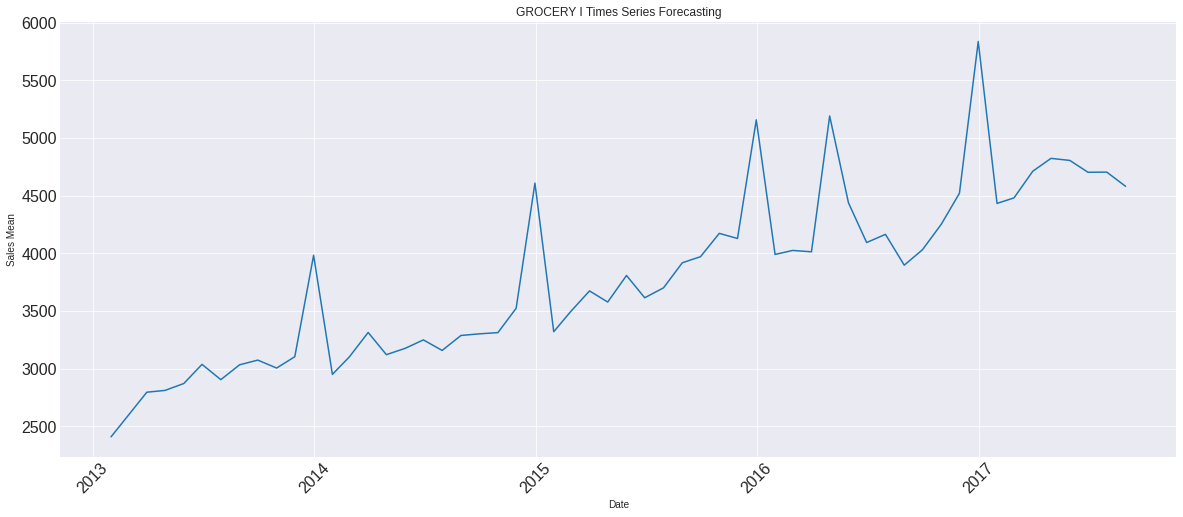

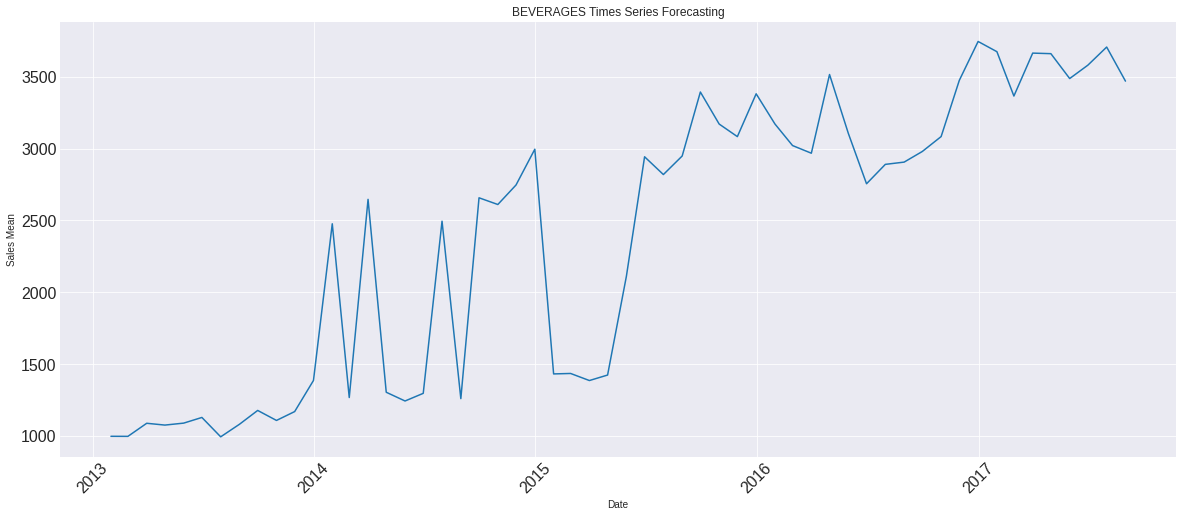

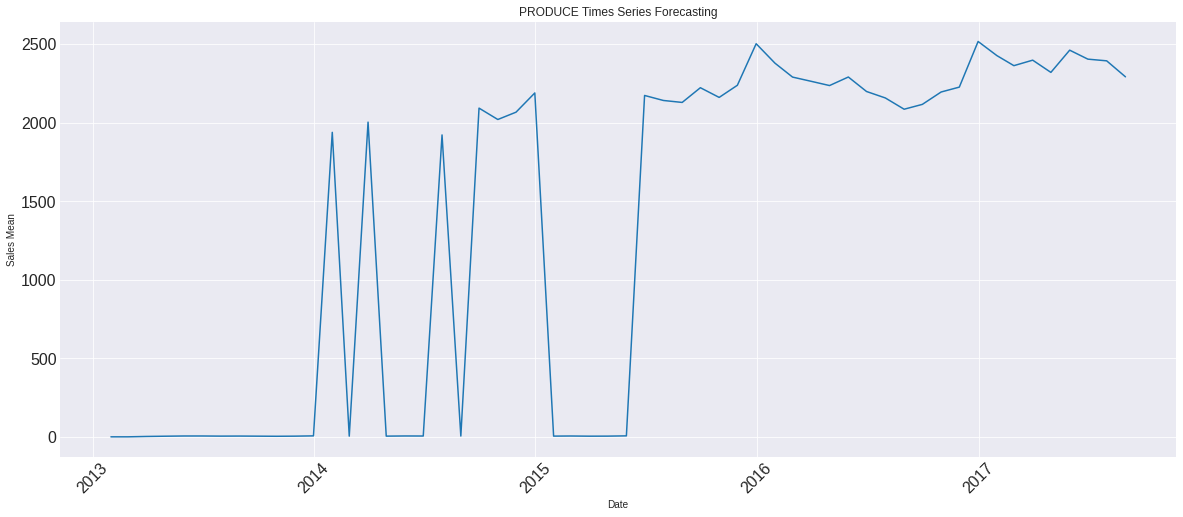

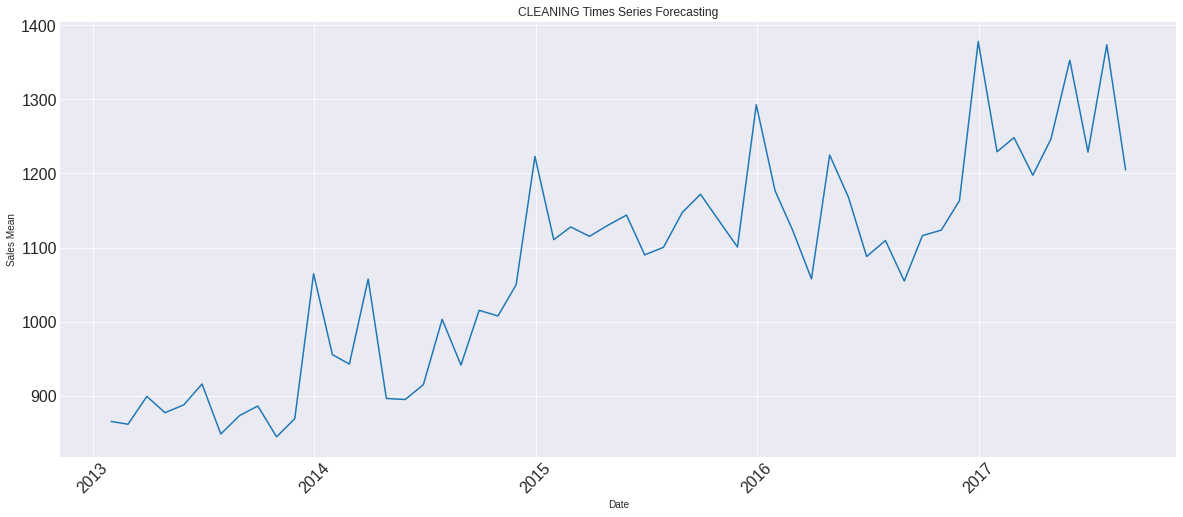

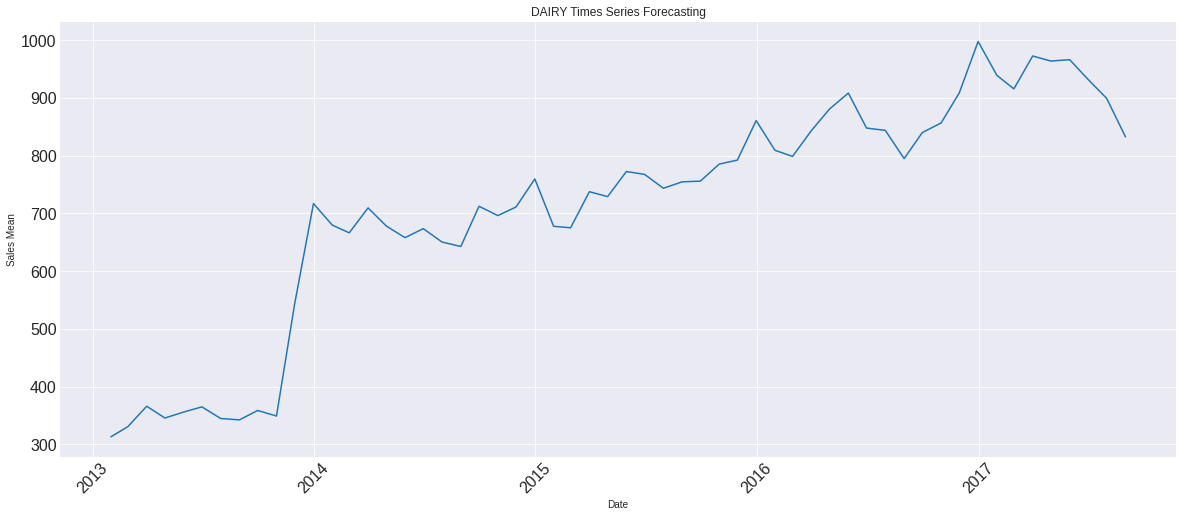

In [40]:
for i in top_5_categories.family.unique():
    
    plt.figure(figsize=(20,8))
    
    sns.lineplot(y = train[['date','sales']][train['family']==i]
                 .resample('M', on='date')
                 .mean()
                 .reset_index(drop=False)['sales']
                 
    , x = train[['date','sales']][train['family']==i]
                 .resample('M', on='date')
                 .mean()
                 .reset_index(drop=False)['date'],linewidth = 1.5)
    
    plt.xlabel('Date')
    plt.ylabel("Sales Mean")
    plt.title('{} Times Series Forecasting'.format(i))
    plt.xticks(rotation=45)
    plt.show()

In [41]:
least_5_categories = train.groupby('family')['sales'].mean().sort_values(ascending=True)[:5].reset_index()

<div class="alert simple-alert">
  <p>💡<b>Note</b>:These are the , 5 grocerie types in sales :) </p>
</div>

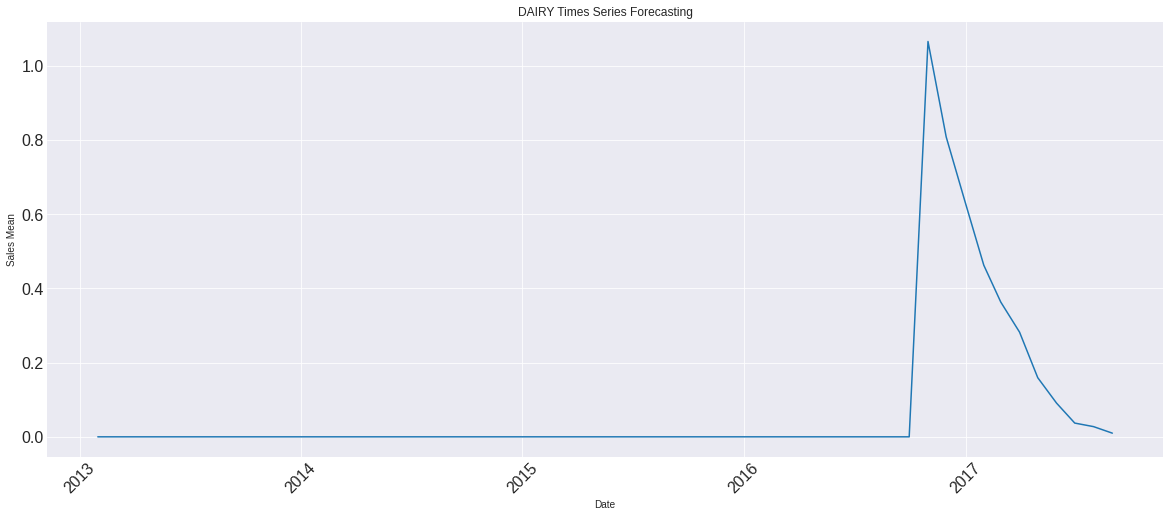

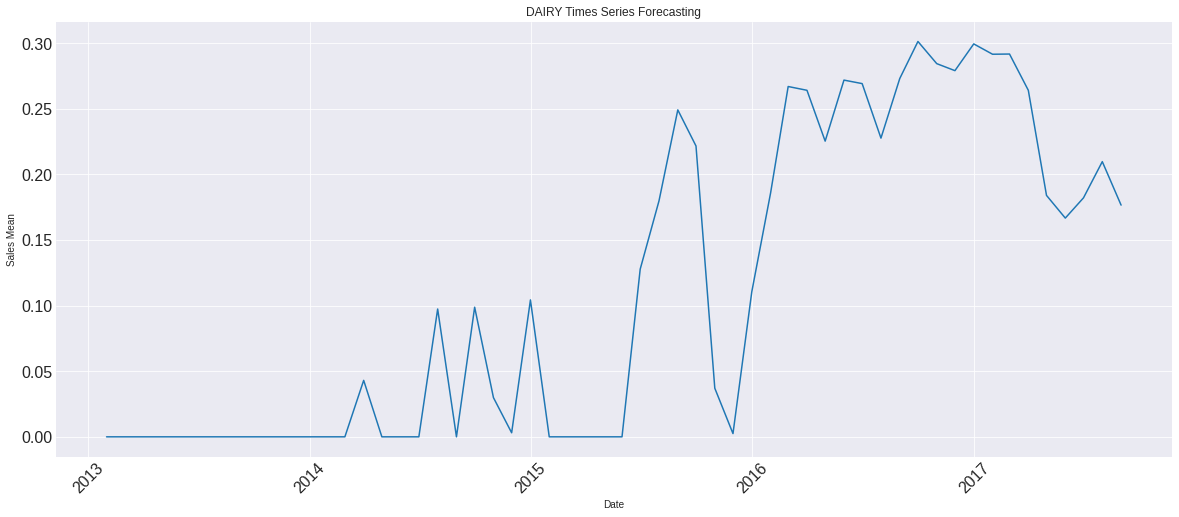

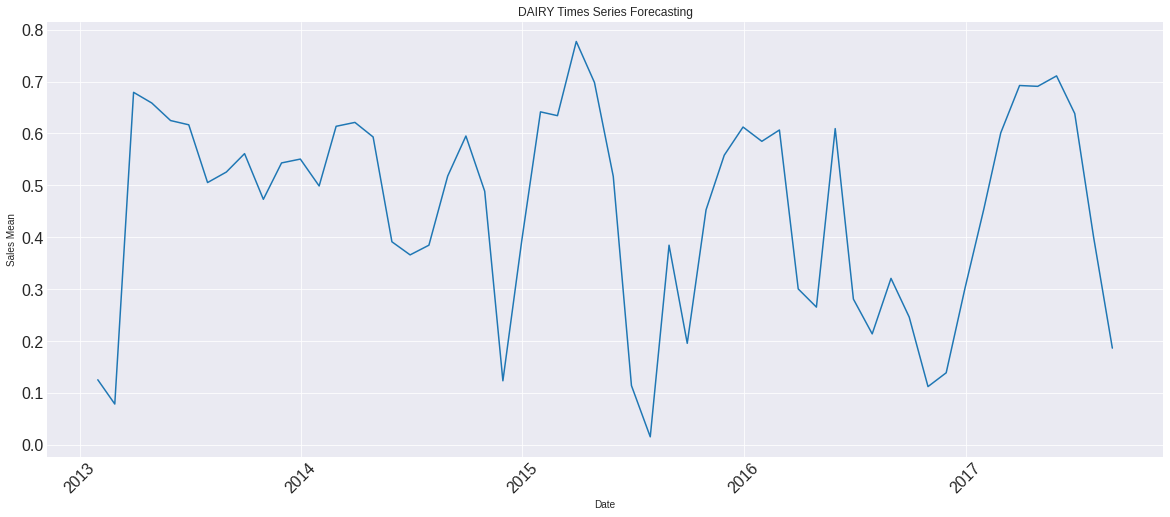

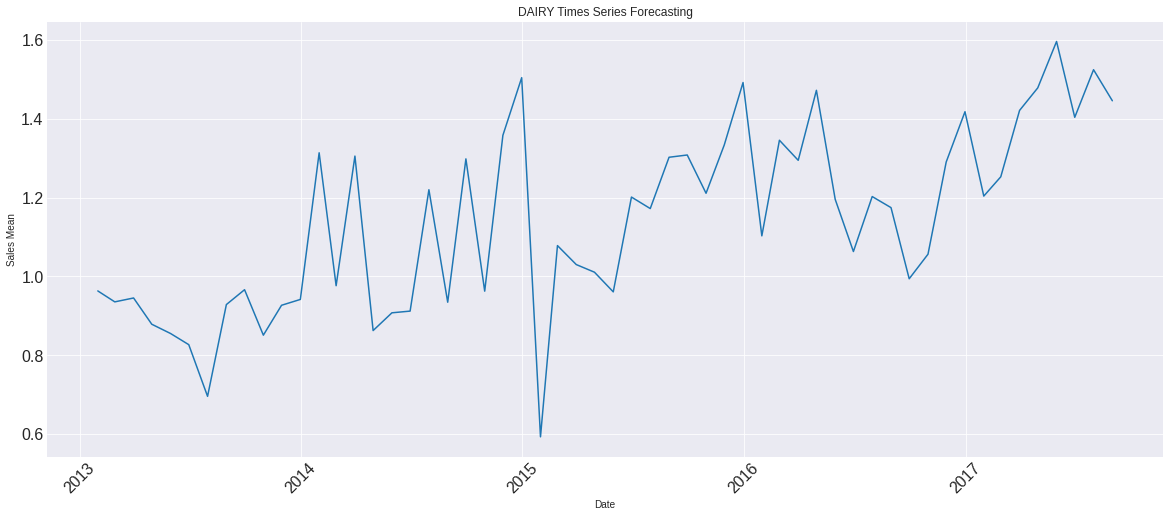

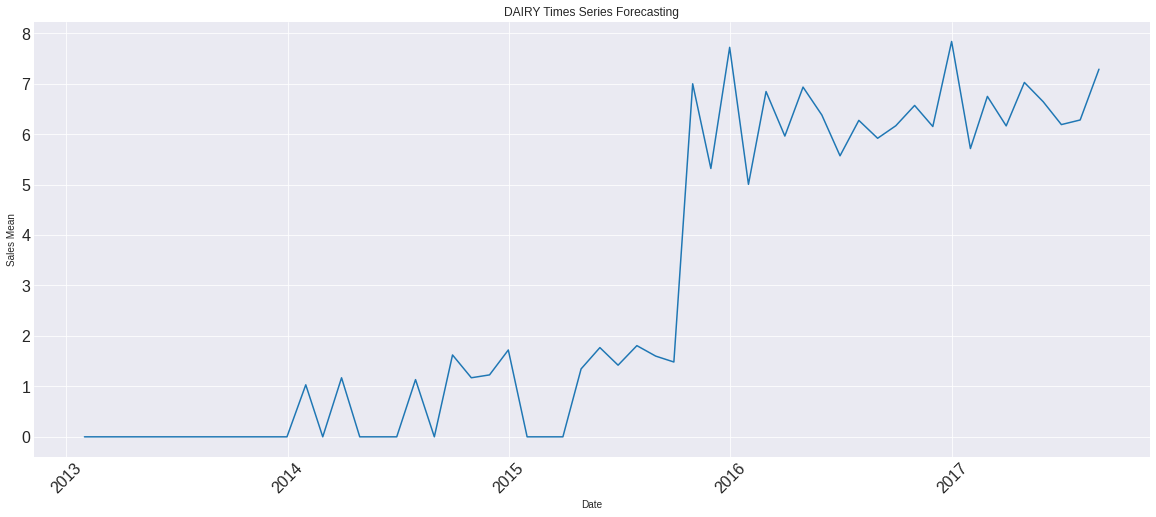

In [42]:
for cat in least_5_categories.family.unique():
    
    plt.figure(figsize=(20,8))
    
    sns.lineplot(y = train[['date','sales']][train['family']==cat]
                 .resample('M', on='date')
                 .mean()
                 .reset_index(drop=False)['sales']
                 
    , x = train[['date','sales']][train['family']==cat]
                 .resample('M', on='date')
                 .mean()
                 .reset_index(drop=False)['date'],linewidth = 1.5)
    
    plt.xlabel('Date')
    plt.ylabel("Sales Mean")
    plt.title('{} Times Series Forecasting'.format(i))
    plt.xticks(rotation=45)
    plt.show()

<a id = 'Further data to analyze'></a>

## 1.2 Further data to analyze (Events, oil, stores) datasets 

**💡 Helpful Notes**:


* Date 
* Type: if its a holiday or not 
* Locale: if this holiday is local or regional 
* locale_name: name of the local city 
* description: brief describtion about the event 


In [44]:
%%time

events = pd.read_csv('/content/holidays_events.csv')

oil = pd.read_csv('/content/oil.csv')

stores = pd.read_csv('/content/stores.csv')

test = pd.read_csv('/content/test.csv')

submission = pd.read_csv('/content/sample_submission.csv')

CPU times: user 40.9 ms, sys: 7.89 ms, total: 48.8 ms
Wall time: 57.4 ms


In [45]:
events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [46]:
events['date'] = pd.to_datetime(events.date) # change column type 

In [47]:
events['year'] = events.date.dt.year # create seperate year column to get an overview per year. 

In [48]:
events['month'] = events.date.dt.month  

In [49]:
events_type_value_counts = events.type.value_counts().reset_index()

In [50]:
px.bar(events_type_value_counts, x='index', y='type',
        labels=dict(index = "Type", type="Frequency"))


In [51]:
count_events = events.groupby("year")['type'].count().reset_index()

In [52]:
count_events # count events per year 

,year,type
0,2012,41
1,2013,51
2,2014,67
3,2015,52
4,2016,86
5,2017,53


In [53]:
px.bar(count_events, x='year', y='type', 
        labels= dict(type="Frequency of events", year= 'Year'))



<div class="alert simple-alert">
  <p>💡<b>Note</b>:Seems like the holidays per year is not equally distributed !!
    We can look for more deeper look on the holidays :)</p>
</div>

In [54]:
events.type.value_counts().reset_index()

,index,type
0,Holiday,221
1,Event,56
2,Additional,51
3,Transfer,12
4,Bridge,5
5,Work Day,5


In [55]:
holidays_or_event = events[(events['type'] == 'Holiday') | (events['type'] == 'Event')] 

In [56]:
holidays_or_event.head()

,date,type,locale,locale_name,description,transferred,year,month
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4


In [57]:
x = holidays_or_event.groupby('year')['type'].value_counts()
x.index

MultiIndex([(2012, 'Holiday'),
            (2013, 'Holiday'),
            (2013,   'Event'),
            (2014, 'Holiday'),
            (2014,   'Event'),
            (2015, 'Holiday'),
            (2015,   'Event'),
            (2016, 'Holiday'),
            (2016,   'Event'),
            (2017, 'Holiday'),
            (2017,   'Event')],
           names=['year', 'type'])

In [58]:
holidays_or_event['month'] = holidays_or_event.date.dt.month 
#let's look for holidays per month to get more consice overview

In [59]:
holidays_or_event_per_year_and_month = holidays_or_event.groupby(['year','month'])['type'].value_counts().reset_index(level=[0,1])

holidays_or_event_per_year_and_month

,year,month,type
type,,,
Holiday,2012,3,1
Holiday,2012,4,4
Holiday,2012,5,1
Holiday,2012,6,4
Holiday,2012,7,3
...,...,...,...
Holiday,2017,8,4
Holiday,2017,9,1
Holiday,2017,10,2


In [60]:
holidays_or_event_per_year_and_month.columns = ['Year', 'Month', 'Count']

In [61]:
holidays_or_event_per_year_and_month = holidays_or_event_per_year_and_month.reset_index()

In [62]:
holidays_or_event_per_year_and_month.head()

,type,Year,Month,Count
0,Holiday,2012,3,1
1,Holiday,2012,4,4
2,Holiday,2012,5,1
3,Holiday,2012,6,4
4,Holiday,2012,7,3


In [63]:
px.line(holidays_or_event_per_year_and_month, y='Count', x='Month', color='Year')

In [64]:
px.line(sales_per_month, x = 'month', y= 'sales', color='year')

In [65]:
event_per_month = events.groupby(['year','month'])['type'].count().reset_index()

In [66]:
px.line(event_per_month, x='month', y='type',color='year',
       labels = dict(month='Month', type='Frequency'))

In [67]:
diff_events = events.locale.value_counts().reset_index()

In [68]:
px.bar(diff_events, x = 'index', y='locale', 
       labels = dict(index='Event Type', locale='Frequency'))

### 1.5 oil dataset 

<div class="alert simple-alert">
  <p>💡<b>Note</b>: We could use oil prices for further investgations by joining this dataset to train dataset. </p>
</div>

In [69]:
oil.head() 
# this dataset give us more information about oil price in a given specific date 

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [70]:
oil['date'] = pd.to_datetime(oil.date)

In [71]:
events.head()

,date,type,locale,locale_name,description,transferred,year,month
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4


In [72]:
events_new = events.drop(['year','month', 'locale', 'locale_name','description', 'transferred'], axis=1)

> We previously managed to investgate on **events** dataset alone but we can merge it with other datasets to make more complex and deeper knowledge.

In [73]:
train.head()

,date,store_nbr,family,sales,onpromotion,year,month
id,,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1
1,2013-01-01,1,BABY CARE,0.0,0,2013,1
2,2013-01-01,1,BEAUTY,0.0,0,2013,1
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1
4,2013-01-01,1,BOOKS,0.0,0,2013,1


In [74]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [75]:
train_stores = train.merge(stores, how='left', on='store_nbr')

In [76]:
events.head()

,date,type,locale,locale_name,description,transferred,year,month
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4


In [77]:
events_new = events.drop(['locale','locale_name', 'description', 'transferred', 'year', 'month'],axis=1)

In [78]:
data = train_stores.merge(events_new, how='left', on= 'date')

In [79]:
data = data.merge(oil, how ='left', on='date')

data.head()

,date,store_nbr,family,sales,onpromotion,year,month,city,state,type_x,cluster,type_y,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN
4,2013-01-01,1,BOOKS,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN


In [80]:
print(clr.S+f"the overall dateset rows is {data.shape[0]} with {data.shape[1]} coulmns."+clr.E)

the overall dateset rows is 3054348 with 13 coulmns.


In [81]:
sales_per_family_per_city = data.groupby(['city','family'])['sales'].sum()
sales_per_family_per_city

city           family                    
Ambato         AUTOMOTIVE                    2.395200e+04
               BABY CARE                     0.000000e+00
               BEAUTY                        1.585900e+04
               BEVERAGES                     7.557310e+06
               BOOKS                         3.880000e+02
                                                 ...     
Santo Domingo  POULTRY                       7.232492e+05
               PREPARED FOODS                3.022572e+05
               PRODUCE                       3.310352e+06
               SCHOOL AND OFFICE SUPPLIES    7.061000e+03
               SEAFOOD                       3.190935e+04
Name: sales, Length: 726, dtype: float64

In [82]:
sales_per_family_per_city = sales_per_family_per_city.reset_index(level=[0,1])
sales_per_family_per_city 

,city,family,sales
0,Ambato,AUTOMOTIVE,2.395200e+04
1,Ambato,BABY CARE,0.000000e+00
2,Ambato,BEAUTY,1.585900e+04
3,Ambato,BEVERAGES,7.557310e+06
4,Ambato,BOOKS,3.880000e+02
...,...,...,...
721,Santo Domingo,POULTRY,7.232492e+05
722,Santo Domingo,PREPARED FOODS,3.022572e+05
723,Santo Domingo,PRODUCE,3.310352e+06
724,Santo Domingo,SCHOOL AND OFFICE SUPPLIES,7.061000e+03


In [83]:
px.bar(sales_per_family_per_city, y='sales', x='city', color='family')

In [84]:
data.head()

,date,store_nbr,family,sales,onpromotion,year,month,city,state,type_x,cluster,type_y,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN
4,2013-01-01,1,BOOKS,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN


In [85]:
stores_per_city = data.groupby('city')['store_nbr'].count().reset_index()


In [86]:
stores_per_city

,city,store_nbr
0,Ambato,113124
1,Babahoyo,56562
2,Cayambe,56562
3,Cuenca,169686
4,Daule,56562
5,El Carmen,56562
6,Esmeraldas,56562
7,Guaranda,56562
8,Guayaquil,452496
9,Ibarra,56562


In [87]:
px.bar(stores_per_city, y='store_nbr', x ='city')

> Seems to me some of our categorical features that have the impact on sales are the following:

* State 
* family 
* city
* type_x
* type_y 

In [88]:
data.head()

,date,store_nbr,family,sales,onpromotion,year,month,city,state,type_x,cluster,type_y,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN
4,2013-01-01,1,BOOKS,0.0,0,2013,1,Quito,Pichincha,D,13,Holiday,NaN


In [89]:
data['week'] = data['date'].dt.isocalendar().week
data['quarter'] = data['date'].dt.quarter
data['day_of_week'] = data['date'].dt.day_name()

In [90]:
df_store_sales = data.groupby('type_x').agg({"sales" : "mean"})\
     .reset_index()\
    .sort_values(by='sales', ascending=False)

df_fam_sales = data.groupby('family').agg({"sales" : "mean"})\
    .reset_index()\
    .sort_values(by='sales', ascending=False)[:10]

df_clus_sales = data.groupby('month').agg({"sales" : "mean"})\
    .reset_index() 

In [91]:
print(px.colors.diverging.RdYlGn.reverse)

<built-in method reverse of list object at 0x7fb85575eaf0>


In [92]:
colors = px.colors.sequential.amp_r
fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Top 10 Highest Product Sales", "Highest Sales in Stores", "Months Vs Sales"))

fig.add_trace(go.Bar(x=df_fam_sales['sales'], y=df_fam_sales['family'], marker=dict(color= colors),
                     name='Family', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_store_sales['sales'], labels=df_store_sales['type_x'], name='Store type',
                     marker=dict(colors=colors), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label'), 
                    row=1, col=2)
fig.add_trace(go.Bar(x=df_clus_sales['month'], y=df_clus_sales['sales'], 
                     marker=dict(color= px.colors.sequential.amp[3]), name='Months'), 
                     row=2, col=1)

# styling -------------------------------------------------------------------------------
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_clus_sales.month, ticktext=[i for i in range(1,17)], row=2, col=1)
fig.update_yaxes(visible=True, row=2, col=1, range=[0,700])
fig.update_layout(height=600, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)

fig.show()


In [93]:
top_city  = stores.groupby('city') .size().sort_values(ascending=False)

In [94]:
stores_nbr_id = data.store_nbr.unique()

In [95]:
stores_nbr_id

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [96]:
sales_grouped = data.groupby(['store_nbr','date']).agg({'sales':'sum'})
sales_by_store_id = {}
for store in range(1,len(stores_nbr_id)):
    sales_by_store_id[store] = {'sale': sales_grouped.loc[store].sales.mean(),
                                'city': stores.city[store],
                                'city-id': stores.city[store]+"-{}".format(store) ,
                                'state': stores.state[store] ,
                                'type': stores.type[store] ,
                                'cluster': stores.cluster[store] }
sales_by_store_id = pd.DataFrame.from_dict(sales_by_store_id, orient='index') # convert to Pandas DataFrame 

sales_by_city      = {}
for city in top_city.index.values:
    sales_by_city[city]      = {'sum': sales_by_store_id [ stores.city==city ].sale.sum(),
                                'mean': sales_by_store_id [ stores.city==city ].sale.mean() }
sales_by_city      = pd.DataFrame.from_dict(sales_by_city, orient='index')    


In [97]:
# Sorting
sales_by_store_id.sort_values( by='sale', inplace=True, ascending=False )
sales_by_city_sum  = sales_by_city.sort_values( by='sum', ascending=False )

In [98]:
sales_by_store_id.head()

,sale,city,city-id,state,type,cluster
44,37622.409281,Quito,Quito-44,Pichincha,A,11
45,33069.490500,Quito,Quito-45,Pichincha,A,14
47,30893.394273,Quito,Quito-47,Pichincha,A,14
3,30601.857563,Quito,Quito-3,Pichincha,D,9
49,26334.217791,Ambato,Ambato-49,Tungurahua,A,14


In [99]:
px.bar(sales_by_store_id, x='city-id', y='sale', title= 'Average sales per given store')

In [100]:
sales_by_store_id.sale.mean()

12159.541280289013

In [101]:
sales_grouped  = data.groupby('date').agg({'sales':'sum'}).to_period("D")
sales_grouped['year']      = sales_grouped.index.year
sales_grouped['quarter']   = sales_grouped.index.quarter
sales_grouped['month']     = sales_grouped.index.month
sales_grouped['week']      = sales_grouped.index.week
sales_grouped['dayofweek'] = sales_grouped.index.dayofweek  # Monday=0, Sunday=6
sales_grouped['dayofmonth']= sales_grouped.index.day  # day in month from 01 to 31
sales_grouped['dayofyear'] = sales_grouped.index.dayofyear

sales_smooth7  = sales_grouped.copy()
sales_smooth30 = sales_grouped.copy()
sales_smooth365= sales_grouped.copy()

sales_smooth7["sales"]   = sales_smooth7.  sales.rolling(window=7,  center=True, min_periods=3 ).mean()
sales_smooth30["sales"]  = sales_smooth30. sales.rolling(window=30, center=True, min_periods=15).mean()
sales_smooth365["sales"] = sales_smooth365.sales.rolling(window=365,center=True, min_periods=183).mean()

[Text(0.5, 1.0, 'Average Sales by Quarter')]

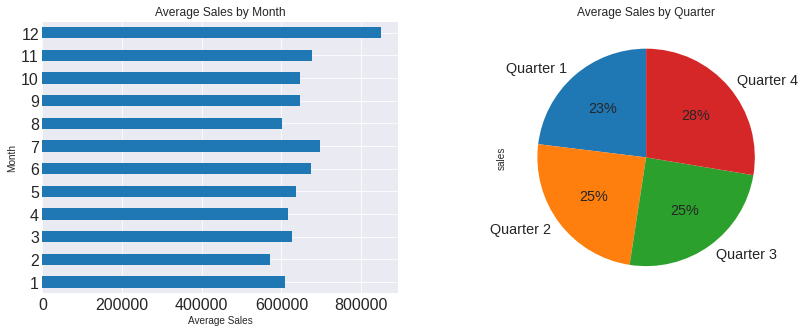

In [102]:
figsize = (14,5)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)

sales_grouped.groupby(['month']).agg({'sales':'mean'}).plot(kind="barh",ax=ax1)

ax1.set(title="Average Sales by Month")
ax1.set(ylabel="Month", xlabel="Average Sales")
ax1.get_legend().remove()

labels1 = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

ax1.set_yticks(range(0,12), labels1)

sales_grouped.groupby(['quarter']).agg({'sales':'mean'}).plot.pie(y="sales",ax=ax2, legend=False, autopct='%1.f%%',
                             startangle=90, labels=["Quarter 1","Quarter 2","Quarter 3","Quarter 4"], fontsize="x-large")
ax2.set(title="Average Sales by Quarter")

<div class="alert simple-alert">
  <p>💡<b>Note</b>: Most of the sales occurred in December. People tend to stock for the end of the year to prepare for a new year or to decorate the house, or schedule for a long holiday starting from Christmas. </p>
</div>

<div class="alert simple-alert">
  <p>💡<b>Note</b>: Although the sales in each quarter are very similar, the last (4th) quarter is the biggist, which agrees to the sales by month where there is a jump in December. </p>
</div>

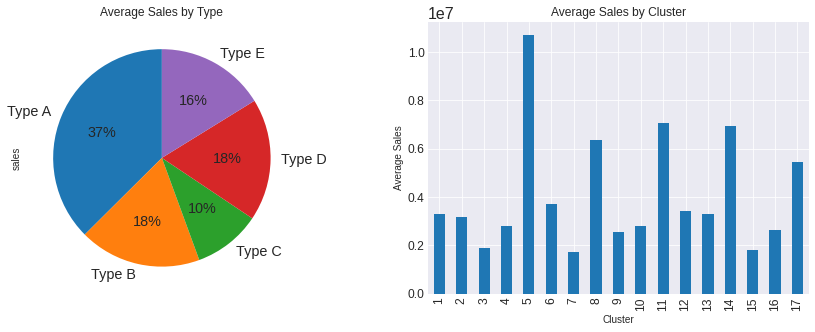

In [103]:
top_stores_2017 = data.loc[data.date.dt.year==2017].groupby("store_nbr").agg({"sales":"sum"})
top_stores_2017 = pd.merge(top_stores_2017, stores, on="store_nbr").drop(["city","state"],axis=1)

figsize = (15,5)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)
top_stores_2017.groupby(['type']).agg({'sales':'mean'}).plot.pie(y="sales",ax=ax1, legend=False, autopct='%1.f%%',
                             startangle=90, labels=["Type A","Type B","Type C","Type D","Type E"], fontsize="x-large")
ax1.set(title="Average Sales by Type")

top_stores_2017.groupby(['cluster']).agg({'sales':'mean'}).plot.bar(ax=ax2,  fontsize="large")
ax2.set(title="Average Sales by Cluster")
ax2.set(ylabel="Average Sales", xlabel="Cluster")
ax2.get_legend().remove()

plt.show()

<div class="alert simple-alert">
  💡<b>Note</b>: 
    
* Store Type A has the highest sales which is 37%, followed by Types B and D.

* Store Cluster 5 has the highest sales, followed by Clusters 11, 14, and 8. 
</div>

### 2. Testing Stationarity 

Our time series data **Can have a trend or not**.It is of the utmost importance to determine how the series is behaving before applying any model to it. 

> **Augmented Dickey Fuller test**: it determines how strongly a time series is defined by a trend. 

#### Hypothesis:

<div class ="alert simple-alert"><p> 1. Null Hypothesis (H0): Null Hypothesis of the test is that the time series can be represented by a unit root that <b>is not stationary</b>.

2. Alternative Hypothesis (H1): Alternative Hypothesis of the test is that the time series **is stationary**.</p> </div>

#### Why is Stationary Important?

<div class = "alert success-alert"><p>For data to be stationary, the statistical properties of a system <b>do not change over time</b>. This does not mean that the values for each data point have to be the same, but the overall behavior of the data should remain constant.

If the data is non-stationary (meaning it has a trend), we need to **remove** it in order to proceed with the analysis.</p></div> 

ADF statistic: -22.241296302700512
p-value: 0.0
The graph is stationary! (it doesn't have a trend)
Critical values:
	1%: -3.431 
	5%: -2.862 
	10%: -2.567 


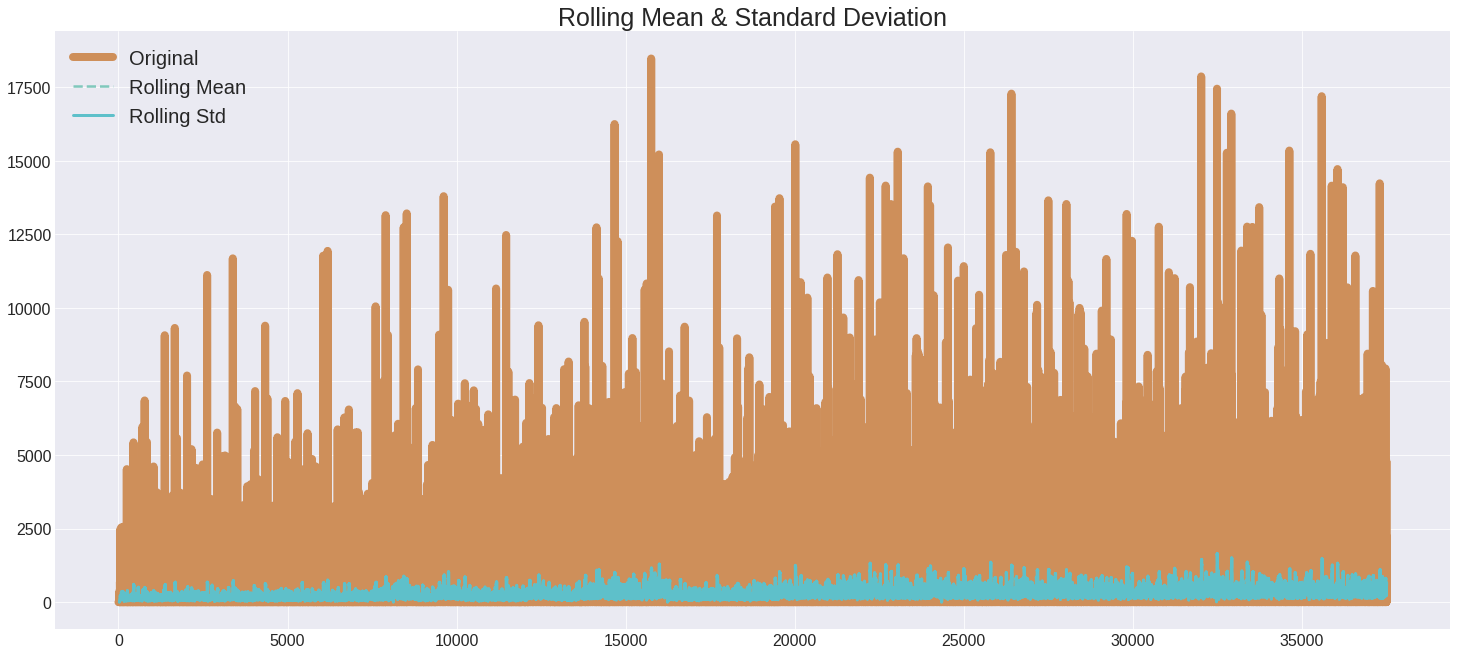

In [104]:
sales = pd.Series(train['sales'][::80].to_numpy())

test_stationarity(sales, log='non-stationary')

<div class="alert danger-alert">
  <p>💡<i>Note</i>: If our data have trends (is non-stationary we could remove this trending by using <b>natural log</b> to our series</p>
</div>

ADF statistic: -12.043565455374308
p-value: 2.6971544781442066e-22
The graph is stationary! (it doesn't have a trend)
Critical values:
	1%: -3.431 
	5%: -2.862 
	10%: -2.567 


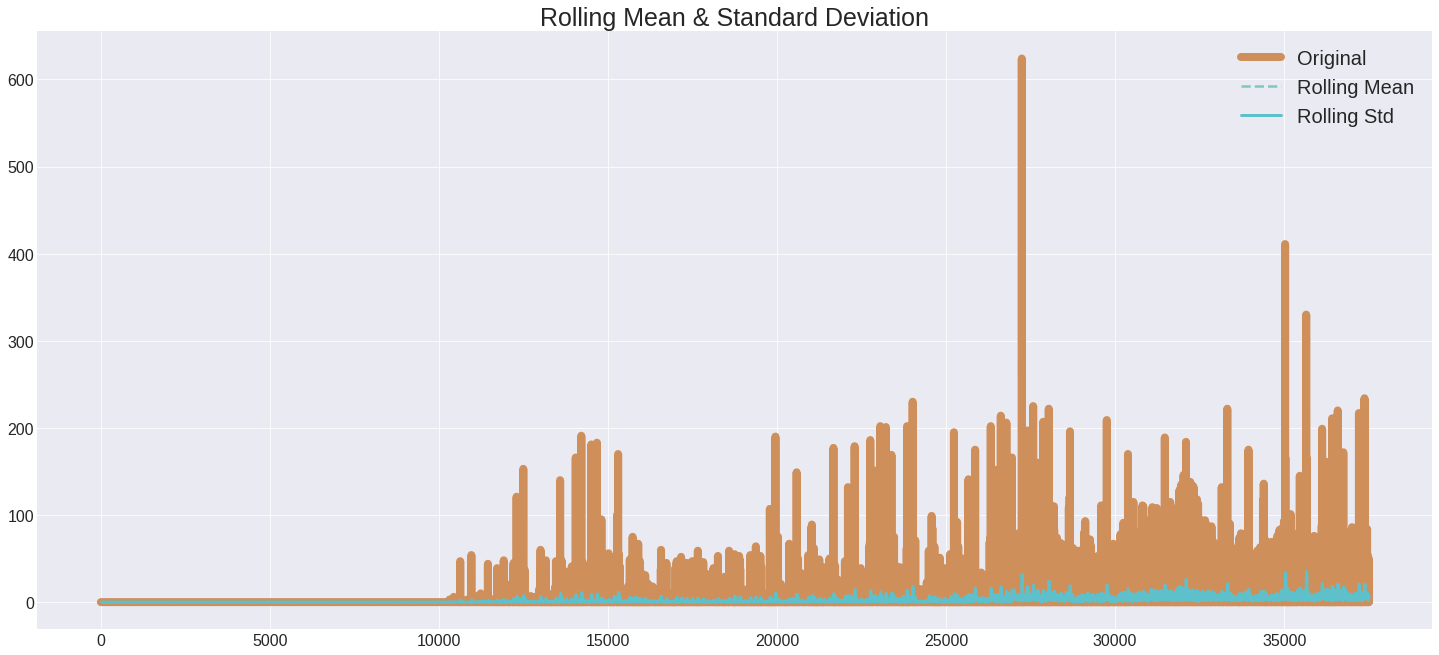

In [105]:
promotion = pd.Series(train['onpromotion'][::80].to_numpy())

test_stationarity(promotion, log='non-stationary')

In [106]:
train.head(3)

,date,store_nbr,family,sales,onpromotion,year,month
id,,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1
1,2013-01-01,1,BABY CARE,0.0,0,2013,1
2,2013-01-01,1,BEAUTY,0.0,0,2013,1


### Scaling of Numerical Features

In [107]:
train.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year', 'month'], dtype='object')

In [108]:
cols = list(train[['sales', 'onpromotion']].columns)
cols

['sales', 'onpromotion']

In [109]:
scaler = MinMaxScaler(feature_range=(0,1))

train[cols] = scaler.fit_transform(train[cols])

In [110]:
train_date = train[cols]

In [111]:
train_data = train.groupby(['date']).agg({'sales':'mean', 'onpromotion':'mean'})
train_data.tail()

,sales,onpromotion
date,,
2017-08-11,0.003718,0.010738
2017-08-12,0.003566,0.006295
2017-08-13,0.003895,0.007030
2017-08-14,0.003424,0.006091
2017-08-15,0.003432,0.008031


In [112]:
px.scatter(train_data, x ='sales', y='onpromotion')